In [58]:
import torch
from torch.nn.functional import interpolate
import json
import numpy as np
import pandas as pd

from math import ceil

from dataset import RwandaFieldsTestSet
from skimage.measure import label

import matplotlib.pyplot as plt
from skimage.morphology import skeletonize,binary_dilation

from utils.test_utils import *

In [228]:
model_path = './results_new/nasa_rfb_UNETPP3D_tu-tf_efficientnet_b1_100epochs_fold3_V12'
model_id = model_path.split('/')[-1]
model,cfg = load_trained_model(model_path,use_last_model=True)
model.cuda()

UnetPlusPlus3D(
  (encoder): TimmUniversalEncoder(
    (model): EfficientNetFeatures(
      (conv_stem): Conv2dSame(4, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (act1): SiLU(inplace=True)
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (act1): SiLU(inplace=True)
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): SiLU(inplace=True)
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
 

In [226]:
data_cfg = cfg['dataset']

if 'resize' not in data_cfg.keys():
    data_cfg['resize'] = None
aug_tfm =  None if 'test_tfm' not in cfg.keys() else cfg['test_tfm']
dataset = RwandaFieldsTestSet(root=data_cfg['root'],months=data_cfg['months'],resize=data_cfg['resize'],aug_tfm=aug_tfm)

if 'positional_encoding' in cfg['model'].keys():
        POS_ENCOD = cfg['model']['positional_encoding']
else:
    POS_ENCOD = False

if 'pad' not in cfg:
    PADSIZE = None
else:
    PADSIZE = cfg['padsize'] if cfg['pad'] else None
if 'resize' not in cfg:
    RESIZE = None
else:
    RESIZE = cfg['resize']


print(PADSIZE,RESIZE)


320 None


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 256, 256])


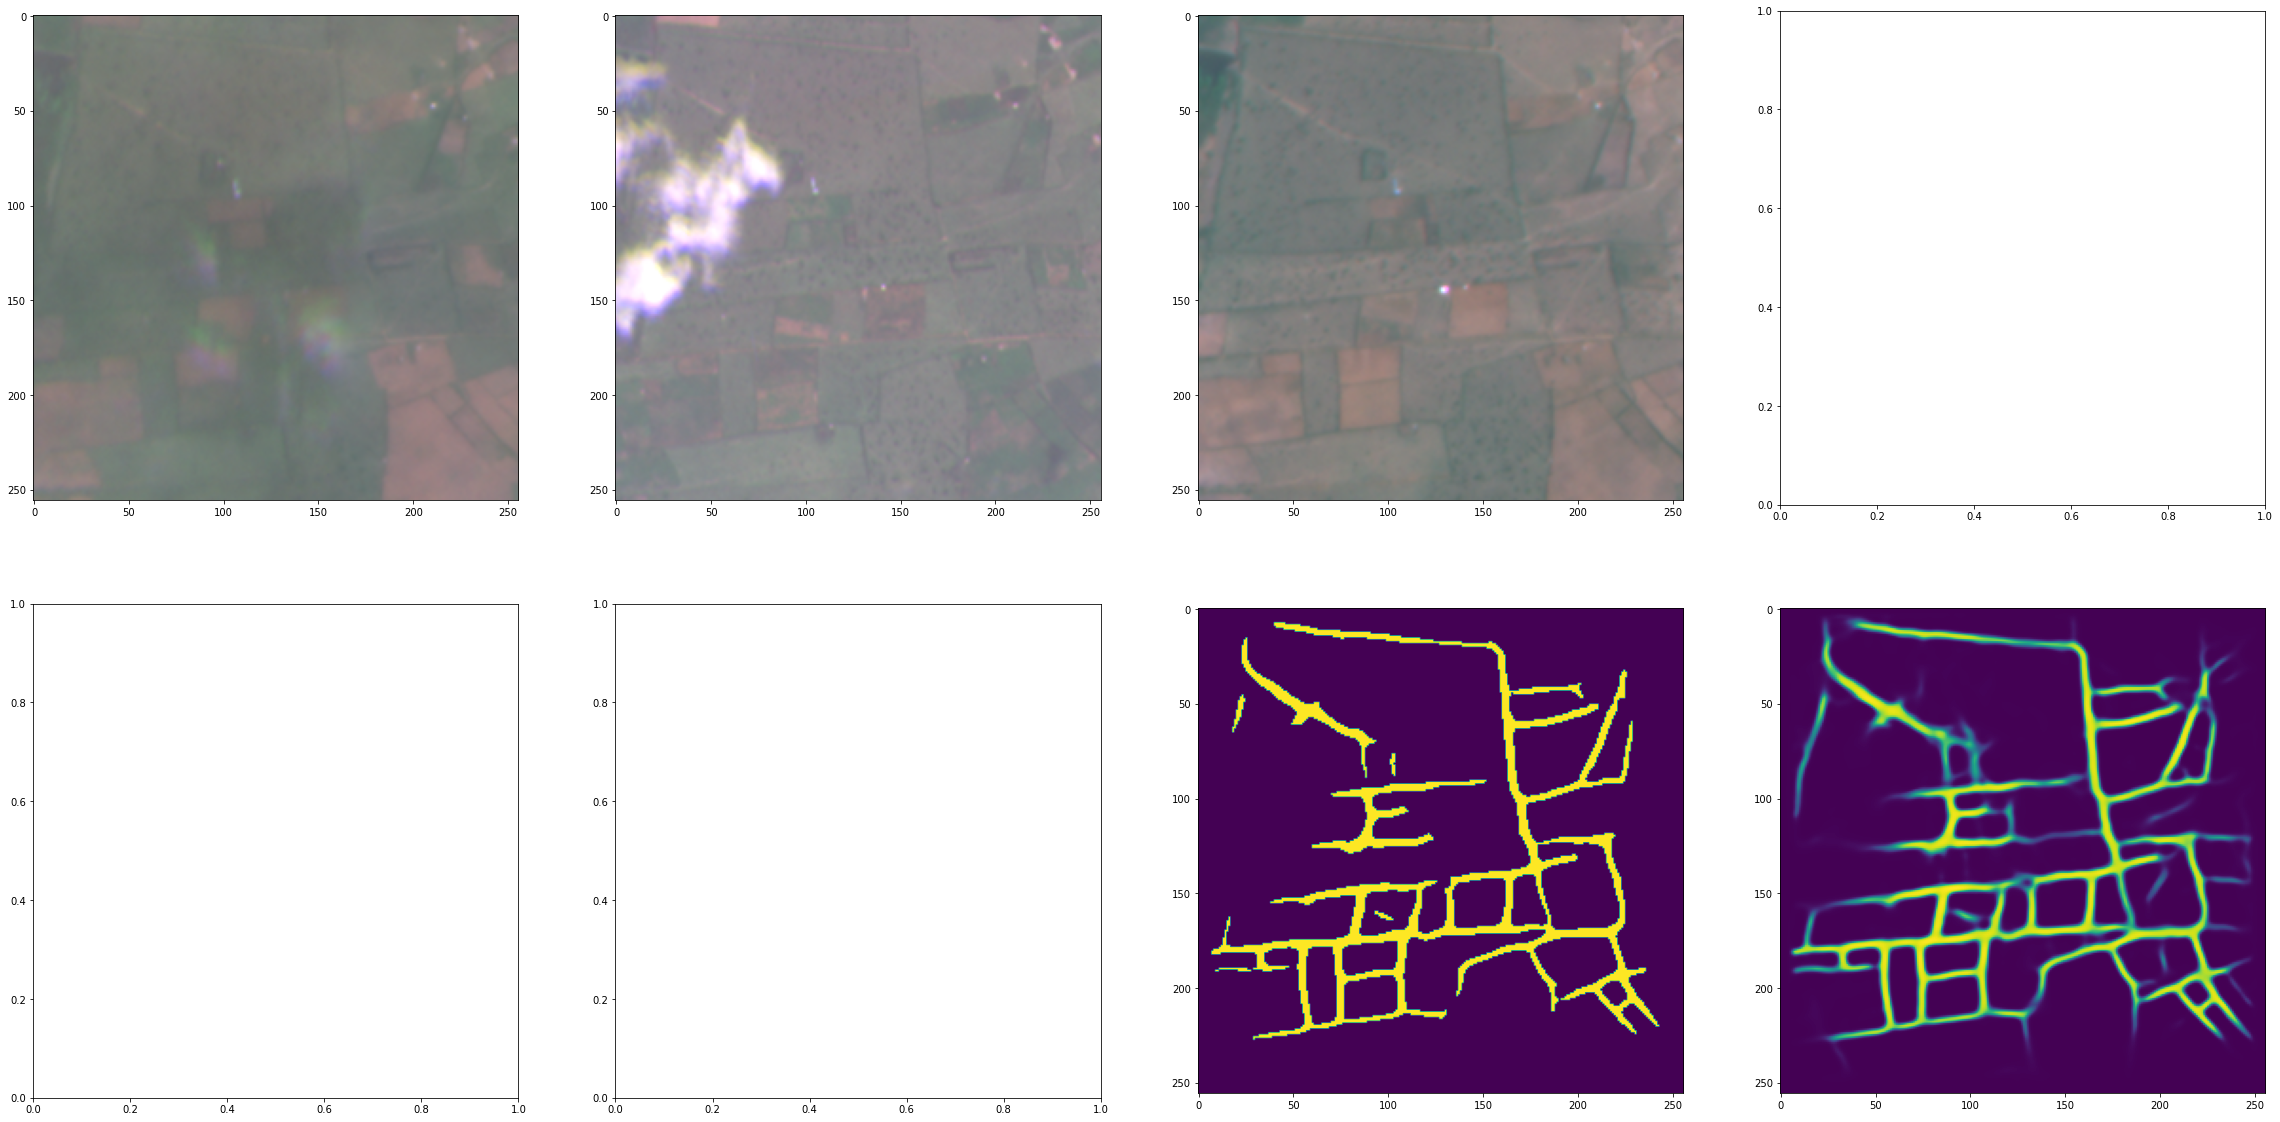

In [229]:
IDX = 9
TTA = True
remove_noise = 20
ret = dataset.__getitem__(IDX)

imgs,dates,iid =ret['x'],ret['dates'],ret['iid']


imgs = imgs.cuda().unsqueeze(0)
dates = dates.cuda().unsqueeze(0)
if TTA:
    imgs = tta(imgs)
    dates = torch.repeat_interleave(dates,repeats=imgs.shape[0],dim=0)

with torch.no_grad():
    if POS_ENCOD:
        y_pred = model(imgs,dates)
    else:
        y_pred = model(imgs)

    y_pred = torch.sigmoid(y_pred)
if TTA:
    y_pred = reverse_tta(y_pred)

    y_pred = y_pred.mean(dim=0).unsqueeze(0)


y_pred = unpad_resize(y_pred,padsize=PADSIZE,resize=RESIZE)[0]
print(y_pred.shape)
imgs = unpad_resize(imgs[0],padsize=PADSIZE,resize=RESIZE).cpu()



y_pred = y_pred.cpu().numpy()[0,...]



fig,axs = plt.subplots(2,4,figsize = (40,20))

B,C,H,W = imgs.shape
for i in range(B):
    img = imgs[i,...].cpu().numpy()        
    img = img.transpose(1,2,0)
    row,col = i // 4, i%4
    
    img = img *2.5
    img = (img + 1)/ 2

    rgb = img[:,:,[2,1,0]]
    axs[row,col].imshow(rgb)



pred_hard = y_pred>0.5
if remove_noise > 0:
    washed = label(pred_hard,background=0,connectivity=2)
    washed = noise_filter(washed,mina=remove_noise)
    pred_hard = washed > 0

cross = np.array([[0,1,0],[1,1,1],[0,1,0]])
skeleton = skeletonize(pred_hard)
skeleton = binary_dilation(skeleton,footprint = cross)
axs[1,2].imshow(pred_hard)
axs[1,3].imshow(y_pred)

#plt.show()


In [198]:
predictions_dictionary = {}

Thresh = 0.5
TTA = True

for i in range(len(dataset)):
    ret = dataset.__getitem__(i)

    imgs,dates,iid =ret['x'],ret['dates'],ret['iid']
    tile_id = str(iid.split('_')[-1]).zfill(2)

    imgs = imgs.cuda().unsqueeze(0)
    dates = dates.cuda().unsqueeze(0)

    if TTA:
        imgs = tta(imgs)
        dates = torch.repeat_interleave(dates,repeats=imgs.shape[0],dim=0)

    with torch.no_grad():
        if POS_ENCOD:
            y_pred = model(imgs,dates)
        else:
            y_pred = model(imgs)

        y_pred = torch.sigmoid(y_pred)
    
    if TTA:
        y_pred = reverse_tta(y_pred)
        y_pred = y_pred.mean(dim=0).unsqueeze(0)

    y_pred = unpad_resize(y_pred,padsize=PADSIZE,resize=RESIZE)#[0]

    
    y_pred = y_pred[0,0,:,:].cpu().numpy()

    pred = (y_pred >= Thresh).astype(np.uint8)
    #print(y_pred.shape)
    #plt.imshow(y_pred)
    predictions_dictionary.update([(str(tile_id), pd.DataFrame(pred))])

In [199]:
dfs = []
for key, value in predictions_dictionary.items():
    ftd = value.unstack().reset_index().rename(columns={'level_0': 'row', 'level_1': 'column', 0: 'label'})
    ftd['tile_row_column'] = f'Tile{key}_' + ftd['row'].astype(str) + '_' + ftd['column'].astype(str)
    ftd = ftd[['tile_row_column', 'label']]
    dfs.append(ftd)

sub = pd.concat(dfs)
sub

,tile_row_column,label
0,Tile00_0_0,0
1,Tile00_0_1,0
2,Tile00_0_2,0
3,Tile00_0_3,0
4,Tile00_0_4,0
...,...,...
65531,Tile12_255_251,0
65532,Tile12_255_252,0
65533,Tile12_255_253,0
65534,Tile12_255_254,0


In [200]:
sub['label'].value_counts()

0    800903
1     51065
Name: label, dtype: int64

In [201]:
if TTA:
    sub.to_csv(f'./submissions/{model_id}_thresh{Thresh}_tta.csv', index = False)
else:
    sub.to_csv(f'./submissions/{model_id}_thresh{Thresh}.csv', index = False)
